**Elliptical Isophote Analysis**  
@author: Ray  
@creation time: 2023-03-22  
@cite:
* [photutils.isophote](https://photutils.readthedocs.io/en/stable/isophote.html)
* [isophote examples](https://github.com/astropy/photutils-datasets/tree/main/notebooks/isophote)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
from astropy.io import fits
from astropy.visualization import MinMaxInterval
from astropy.visualization import ImageNormalize
from astropy.visualization import LogStretch
import photutils
photutils.__version__

'1.6.0'

# Create a simulated galaxy image
* using the [class Gaussian2D](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Gaussian2D.html#gaussian2d) to create the mock image

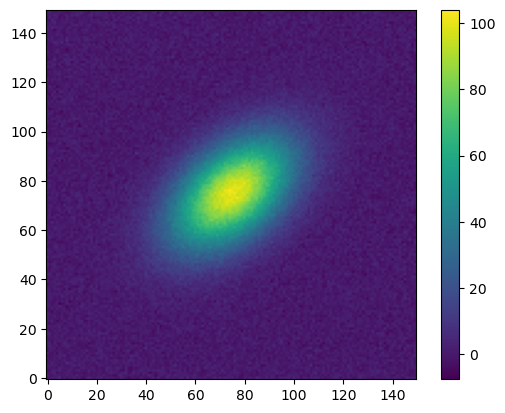

In [2]:
from astropy.modeling.models import Gaussian2D
from photutils.datasets import make_noise_image

g = Gaussian2D(amplitude=100, x_mean=75, y_mean=75, 
               x_stddev=20, y_stddev=12, theta=40.0*np.pi/180)
ny = nx = 150
y, x = np.mgrid[0:ny, 0:nx]
noise = make_noise_image((ny, nx), distribution='gaussian', mean=0.0, stddev=2.0,
                         seed=1234)
data = g(x, y) + noise

plt.imshow(data, origin='lower')
plt.colorbar();

# initial ellipse
* create an initial ellipse to be fitted
* When build an instense of Ellipse class, the default EllipseGeometry instance as an initial argument will be input, which is centered on the image frame, ellipticity of 0.2 and PA of 90 degrees.
* So, giving a initital ellipse geometry is better than using the default one.

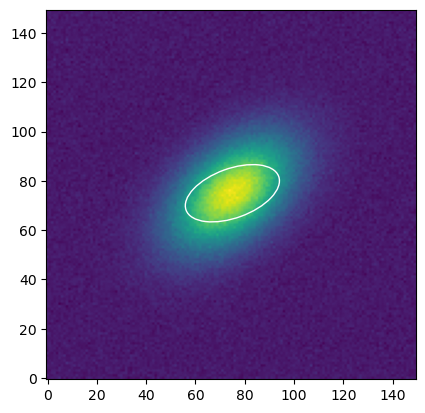

In [3]:
# create the initial ellipse
from photutils.isophote import EllipseGeometry
geometry = EllipseGeometry(x0=75, y0=75, sma=20, eps=0.5, pa=20*np.pi/180)

# plot the elliptical aperture
from photutils.aperture import EllipticalAperture
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma, b=geometry.sma*(1-geometry.eps), 
                          theta=geometry.pa)

plt.imshow(data, origin='lower')
aper.plot(color='white');

# begin fitting using the initial ellipse
* this step is not only for faster but also make the fit successfully.
* create an instance of the Ellipse class
* input 1: the image data
* input 2: the initial ellipse geometry object

In [4]:
# create an instance
from photutils.isophote import Ellipse
ellipse = Ellipse(data, geometry)

# perform fitting
isolist = ellipse.fit_image()

In [5]:
# all results is saved in the isolist class
isolist.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,103.36607432416169,0.0,0.0,0.0,0.0,0.0,0.0,None,None,74.06245821174777,0.0,75.8213678132062,0.0,1,0,0,0
0.5346972612827552,101.85768895649281,0.0301600636268039,0.08332818963700249,0.04790006440231614,1.4812759347946,17.754444345592546,-3.835722930810873,0.8790126604868234,0.2291647953573643,74.06245821174777,0.013961234461624164,75.8213678132062,0.013219371845396474,13,0,10,0
0.5881669874110307,101.68151127888994,0.028309574097376725,0.08901309324430733,0.042083976850879404,0.7118611926761539,14.650171354656678,-3.701560794782021,0.7730019626395571,0.2088313566885717,74.07192943948452,0.013604655597978096,75.80107025064453,0.012719898649920978,13,0,10,0
0.6469836861521338,101.5056710431817,0.02586686730155349,0.10054192188687075,0.03595267359545057,0.16129468081268308,11.14728886096615,-3.5472637840515664,0.6642406314870086,0.18725436616059465,74.08328072504203,0.01293755341324401,75.77850303894112,0.012004484788204768,13,0,11,0
0.7116820547673471,101.37217657344247,0.03226254603814742,0.13948305733759886,0.04124829435933004,177.93414662104902,9.40653434687187,-3.3625097445394223,0.7591990966591431,0.22578346364409835,74.09447359956775,0.017063299626639158,75.7659095929563,0.015137308242345026,13,0,10,0
0.7828502602440819,101.18623292487126,0.03614043830849437,0.1417751576936847,0.042507277412266536,172.6895374639295,9.555137255276366,-3.3100606523654674,0.7462734339638862,0.22545612069995669,74.10804387396634,0.019371825572589173,75.73705658667954,0.017213632807144053,13,0,10,0
0.8611352862684901,100.96986019846082,0.03260830860008341,0.12172259670548968,0.041613889548072436,166.95469535401796,10.772407597836182,-2.840116364309412,0.7688857344468282,0.27072332109666447,74.13340027290923,0.020332748098517334,75.68628803130935,0.01862374621036602,13,0,10,0
0.9472488148953392,100.79135288349151,0.04825217487512524,0.09061431038938372,0.0554860316056595,148.00659556947878,18.986825013694627,-2.966073836563327,0.9646664618217469,0.3252334618006233,74.16908428285358,0.02843310104099889,75.5998293399923,0.027642829072519866,13,0,10,0


# plot the result

## the distribution with the semi major axis

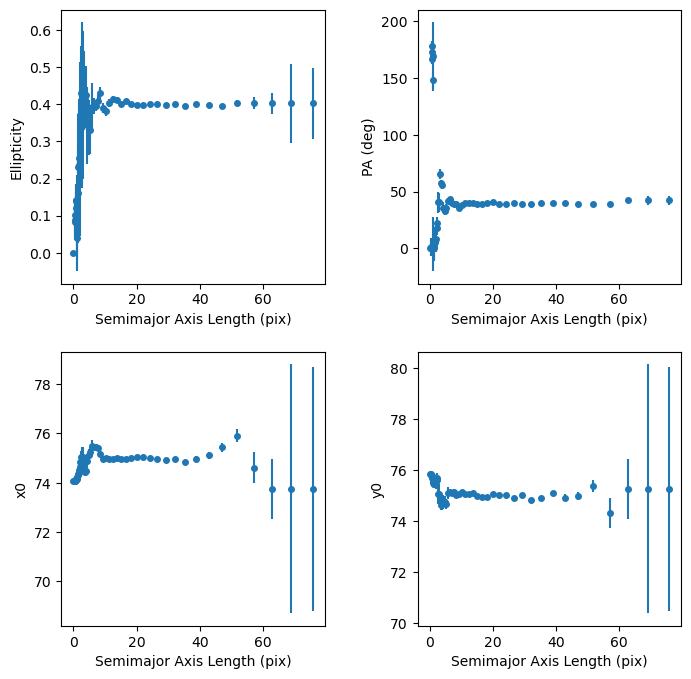

In [6]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.25, wspace=0.35)

plt.subplot(2, 2, 1)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
             fmt='o', markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('Ellipticity')

plt.subplot(2, 2, 2)
plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.0,
             yerr=isolist.pa_err / np.pi * 80.0, fmt='o', markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('PA (deg)')

plt.subplot(2, 2, 3)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
             markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('x0')

plt.subplot(2, 2, 4)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
             markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('y0');

## build an ellipse model

In [7]:
from photutils.isophote import build_ellipse_model
model_image = build_ellipse_model(data.shape, isolist)
residual = data - model_image

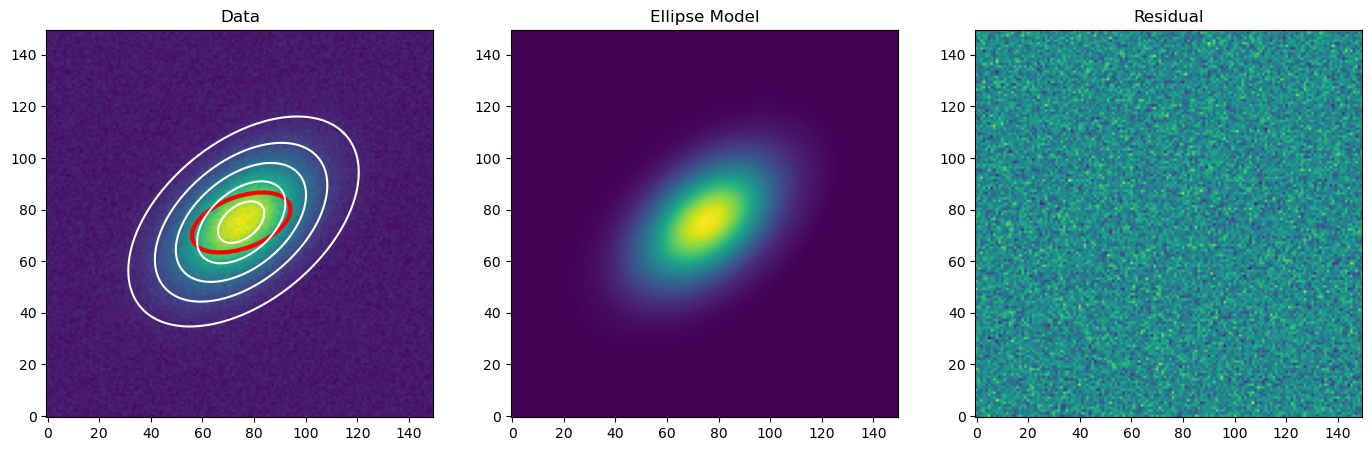

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(data, origin='lower')
ax1.set_title('Data')

smas = np.linspace(10, 50, 5)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

aper.plot(color='red', ax=ax1, lw=3)

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual');

# Example1: A real example for M51 galaxy
* The M51 galaxy was used extensively in the classical software IRAF.
* Reusing it for the sake of consistency.
* Why use a spiral galaxy to apply the elliptical analysis?  
    A: Checking the resilience of the algorithm against image contamination by non-elliptical features.
* image url: https://github.com/astropy/photutils-datasets/tree/main/data/isophote 
* cite: https://github.com/astropy/photutils-datasets/blob/main/notebooks/isophote/isophote_example1.ipynb

## load the image data

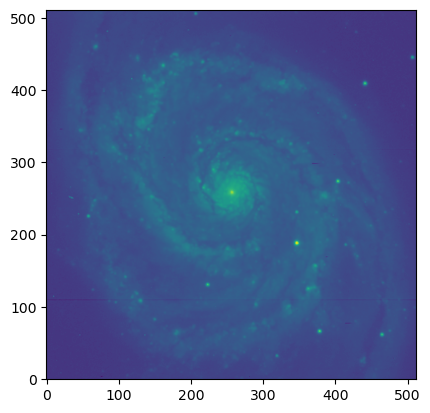

In [9]:
# open the M51 image as fits hdul
hdul = fits.open("./material/M51.fits")
data = hdul[0].data

norm = ImageNormalize(data, interval=MinMaxInterval(), stretch=LogStretch())
plt.imshow(data, origin='lower', norm=norm);

## elliptical fitting

In [10]:
ellipse = Ellipse(data)
isolist = ellipse.fit_image()
isolist.to_table()  # display the results

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,7592.448560431913,0.0,0.0,0.0,0.0,0.0,0.0,None,None,256.8862898968586,0.0,257.9829367476408,0.0,1,0,0,0
0.5209868481924366,6870.575931770033,21.17536508288652,0.04146313436176308,0.08556481353181038,134.52256665156517,62.38542997447069,-1615.7505318470953,606.5541907780705,0.3754008919215204,256.8862898968586,0.023138618601772052,257.9829367476408,0.023143074820460154,13,0,10,0
0.5730855330116803,6788.055446466535,23.354217819168646,0.04146313436176308,0.08630541140791449,135.4215200151438,62.92462149863712,-1608.1273862516737,607.598422590171,0.37782978375015447,256.87741904678455,0.025676997420071682,257.9802431352714,0.025672630776071875,13,0,10,0
0.6303940863128483,6705.698953502874,26.007399634093876,0.05441763619948785,0.0857102940136597,143.1969374118319,47.93120890825641,-1616.4966473756863,598.9451072150111,0.3705204759857517,256.8588669160266,0.028338665435675602,257.988850095413,0.028136082470360254,13,0,10,0
0.6934334949441332,6605.663418483447,26.94020203922787,0.05441763619948785,0.08131399957047364,140.39602037458624,45.47238768343647,-1602.4192689599174,565.569330337454,0.35294716014276845,256.85041570706386,0.029542755125140804,257.9802009130765,0.02940397155567988,13,0,10,0
0.7627768444385465,6505.0884620639035,27.87532354300282,0.06461583618423167,0.07881870230285312,133.90056303670184,37.31677213935522,-1540.1190036170651,544.404135023136,0.353481863248599,256.83822171414323,0.031581133584565234,257.9778077308802,0.031624806733651555,13,0,10,0
0.8390545288824012,6393.173252589307,30.60528362351048,0.06998569114982403,0.07235999368165855,139.5698688179602,31.718049049238314,-1661.528861898073,495.4678805566341,0.2981999843148248,256.8213641783924,0.03211533132035942,257.97786833938704,0.031903127508968905,13,0,10,0
0.9229599817706413,6242.943524876632,32.388148034661256,0.042764717417286005,0.06440819024587949,119.87402257932602,45.56056531951041,-1820.2552905441387,485.9429921034815,0.2669641970705197,256.80527458410677,0.030779089024974803,257.9886898040947,0.03098007488535166,13,0,50,2


## Running Ellipse in a finer-grained way

### Using `fit_isophote` method to fit individual ellipse

In [11]:
isophote = ellipse.fit_isophote(sma=20.)
isophote.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
20.0,734.4221334245929,7.140777830759198,0.1858978273976048,0.01773159424377169,34.04174707194,3.0375891812480726,-47.239138968471984,5.440604993336748,0.1151715529143721,257.6759333378153,0.20355549846931387,259.400382258131,0.19275774768981394,114,0,13,0


In [12]:
type(isophote), type(isolist)  # notice they are different

(photutils.isophote.isophote.Isophote,
 photutils.isophote.isophote.IsophoteList)

### Do not use a for loop instead of the `fit_image` method
* both of two methods are sensitive to the initial guesses
* the `fit_image` method takes care of handling many details about this.

In [13]:
# To prove the fitting is sensitive to the initial guesses

# create an initial guesses
x0 = 256  # center position
y0 = 256  # center position
sma = 20  # semimajor axis length in pixels
eps = 0.2  # ellipticity
pa = 35/180 * np.pi  # PA (counterclockwise from the x axis)

g1 = EllipseGeometry(x0, y0, sma, eps, pa)
g2 = EllipseGeometry(x0+1, y0, sma, eps, pa)

In [14]:
# create an instance of ellipse
ellipse = Ellipse(data, geometry=g1)
isophote = ellipse.fit_isophote(sma=20)
isophote.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
20,733.6213837025307,7.231108278707646,0.18427111326551188,0.01806784684618713,35.0,3.1169590782077585,-47.11752643699424,5.462744659092242,0.1159386978091273,257.6853489691211,0.2066507245468335,259.3475026057055,0.19662174847386568,114,0,10,0


In [15]:
# create another instance of ellipse
ellipse = Ellipse(data, geometry=g2)
isophote = ellipse.fit_isophote(sma=20)
isophote.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
20,733.1280687781958,7.218497312367299,0.1835564176222581,0.018005379225251143,35.0,3.1158234665650473,-47.245622758450786,5.463218591727196,0.1156343862723239,257.6716566012067,0.20579679546716068,259.36306819561037,0.1958255630995951,114,0,10,0


### Break down the fit process
* work with the `EllipseSample` and `EllipseFitter` classes

In [16]:
from photutils.isophote import EllipseSample, EllipseFitter

# create an instance of ellipse, which encapsulates everthing associated with a given elliptical path over the image
sample = EllipseSample(data, sma=7, geometry=g1)

# using sample to create an instance of EllipseFitter
fitter = EllipseFitter(sample)
isophote = fitter.fit()

isophote.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
7,1285.6538042046036,8.223191316392237,0.08204700648319652,0.026040785469624652,120.69896029622994,9.659099994170735,-123.40183380810231,17.253344463286144,0.13981432796303653,256.804606566476,0.09498363823173596,258.50211817828006,0.09707390693849016,43,0,10,0


show the raw values extracted from the image after fitting

In [17]:
# the shape of the sample values
isophote.sample.values.shape

(3, 43)

In [18]:
# PA in radians
isophote.sample.values[0]

array([0.05      , 0.19289046, 0.33623695, 0.48053888, 0.62621849,
       0.7735864 , 0.92281361, 1.07391266, 1.22673069, 1.38095692,
       1.53614606, 1.69175714, 1.84720452, 2.00191567, 2.15538822,
       2.30723907, 2.45723925, 2.6053314 , 2.75162926, 2.89640132,
       3.04004231, 3.18303648, 3.32591652, 3.46922106, 3.61345292,
       3.75904001, 3.90630047, 4.05541432, 4.20640392, 4.35912624,
       4.51327948, 4.66842545, 4.82402757, 4.97950129, 5.13427164,
       5.28783056, 5.43978665, 5.58990104, 5.73810592, 5.88450512,
       6.02935855, 6.17305436, 6.31607255])

In [19]:
# polar radii in pixels
isophote.sample.values[1]

array([6.99836787, 6.97610384, 6.9299143 , 6.86437836, 6.78573799,
       6.70119094, 6.61817513, 6.54373039, 6.48398145, 6.4437497 ,
       6.42627782, 6.43304501, 6.46365843, 6.51582279, 6.58540935,
       6.6666587 , 6.75255246, 6.83537017, 6.90740993, 6.96180107,
       6.99329232, 6.99887825, 6.97814607, 6.93328062, 6.86874102,
       6.79068891, 6.70628534, 6.62297288, 6.54783107, 6.48705163,
       6.44554276, 6.42664773, 6.43195515, 6.46118601, 6.51215817,
       6.58084852, 6.66158669, 6.74741584, 6.83063868, 6.90352972,
       6.95914544, 6.99211764, 6.99929342])

In [20]:
# intensities
isophote.sample.values[2]

array([1279.89476224, 1322.5433036 , 1336.37110703, 1307.42148007,
       1257.52047963, 1198.33051999, 1165.56116733, 1209.0346277 ,
       1307.6014154 , 1389.12093094, 1416.31888459, 1380.55222936,
       1301.20924832, 1212.21262031, 1170.76943548, 1237.58506722,
       1331.98261242, 1336.61024754, 1280.77653313, 1239.33173473,
       1244.6731773 , 1280.57381298, 1307.17316322, 1306.25089889,
       1307.34586513, 1273.7606495 , 1272.55286268, 1281.7699348 ,
       1297.71639944, 1312.16531492, 1323.4459418 , 1310.68206345,
       1275.22733536, 1230.78578669, 1211.09051171, 1251.1027774 ,
       1310.25528941, 1346.20010578, 1345.88064435, 1317.11708252,
       1268.42411957, 1252.34667819, 1275.82475869])

## plotting results

### brightness profile

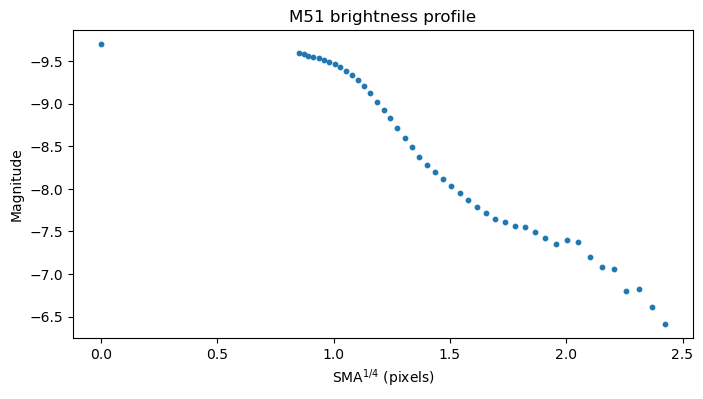

In [21]:
plt.figure(figsize=(8, 4))

plt.scatter(isolist.sma**0.25, -2.5*np.log10(isolist.intens), s=10)
plt.title("M51 brightness profile")
plt.xlabel("SMA$^{1/4}$ (pixels)")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()


### ellipse geometry as a function of SMA length

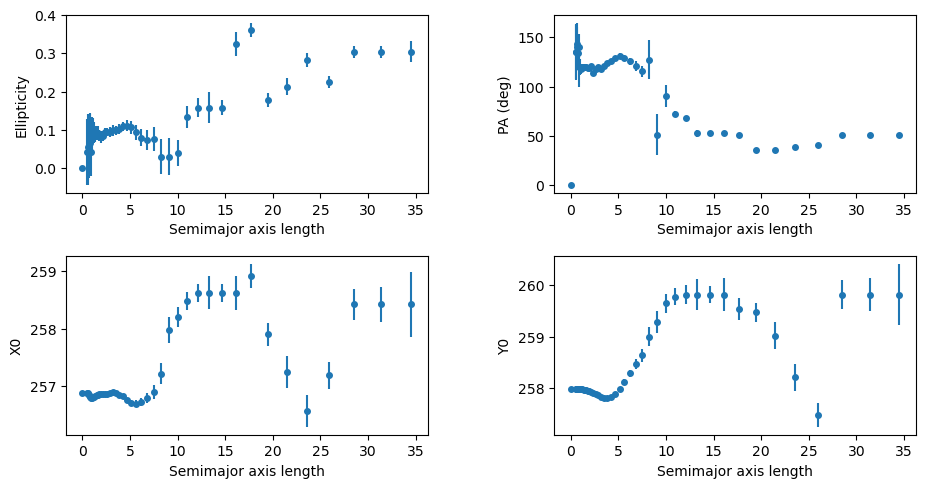

In [22]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Ellipticity')

plt.subplot(222)
plt.errorbar(isolist.sma, isolist.pa/np.pi*180., yerr=isolist.pa_err/np.pi* 80., fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('PA (deg)')

plt.subplot(223)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('X0')

plt.subplot(224)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Y0')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

### plot the ellipse on the image

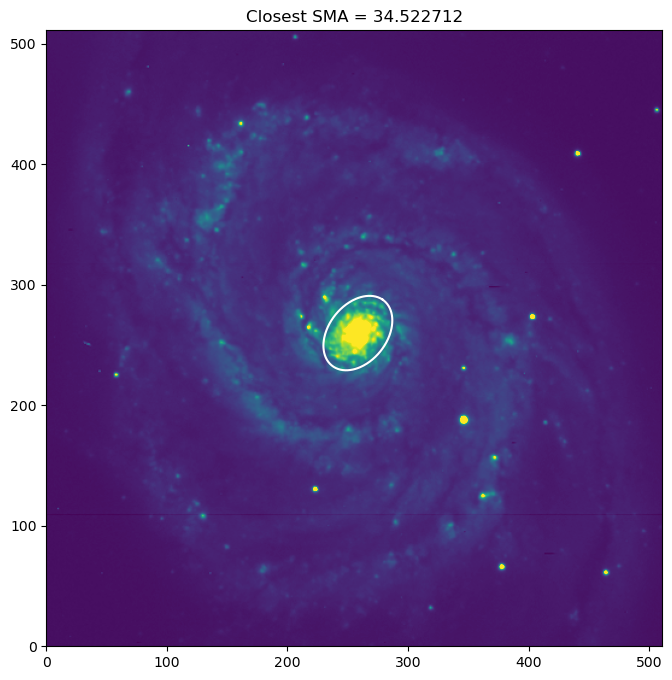

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data, vmin=0, vmax=1000)
plt.axis([0, 511, 0, 511])

# this method on an IsophoteList instance will retrieve the isophote 
# that has the closest 'sma' from the passed argument.
iso = isolist.get_closest(240.)
plt.title('Closest SMA = {:f}'.format(iso.sma))

# this method on an Isophote instance returns the (x, y) coordinates of 
# the sampled points in the image.
x, y, = iso.sampled_coordinates()

plt.plot(x, y, color='white')

### the brightness distribution around the ellipse

Text(0.5, 0, 'Angle (deg)')

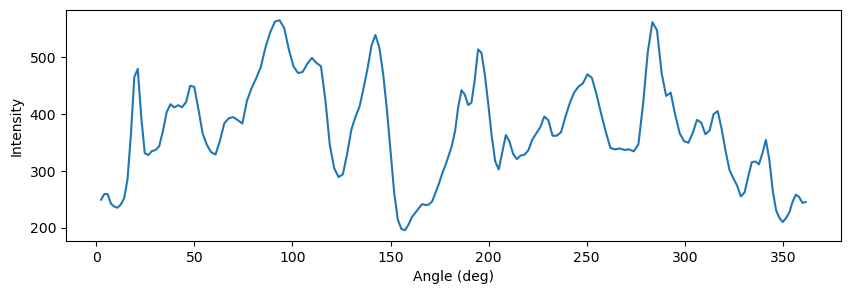

In [24]:
plt.figure(figsize=(10, 3))
iso = isolist.get_closest(40.)
plt.plot(iso.sample.values[0] / np.pi * 180., iso.sample.values[2])
plt.ylabel("Intensity")
plt.xlabel("Angle (deg)")

# Test: fitting a PSF

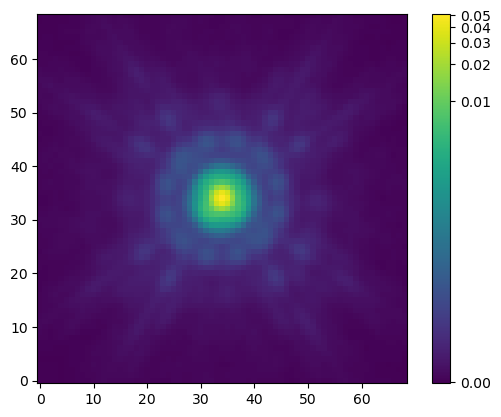

In [33]:
path = "/Users/rui/Code/1_Astronote/18_photutils/material/aegis_3dhst.v4.0.F160W_psf.fits"
data = fits.getdata(path)

norm = ImageNormalize(data, interval=MinMaxInterval(), stretch=LogStretch())
plt.imshow(data, norm=norm, origin='lower')
plt.colorbar();

In [57]:
from photutils.detection import find_peaks
tbl_peak = find_peaks(data, threshold=np.mean(data), box_size=10)
tbl_peak['x_peak'].data[0]

34

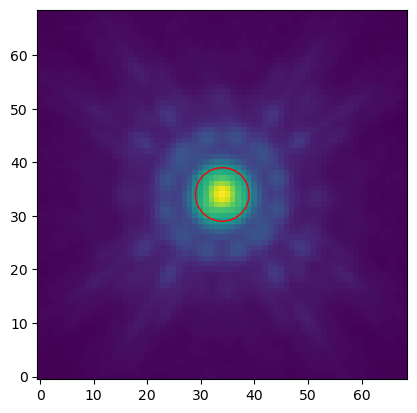

In [72]:
# create an initial ellipse geometry

from photutils.isophote import EllipseGeometry
x0, y0 = tbl_peak['x_peak'].data[0], tbl_peak['y_peak'].data[0]
geometry = EllipseGeometry(x0, y0, eps=0, pa=0, sma=5)

# plot the elliptical aperture
from photutils.aperture import EllipticalAperture
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma, b=geometry.sma*(1-geometry.eps), 
                          theta=geometry.pa)
plt.imshow(data, norm=norm, origin='lower')
aper.plot(color='red');


In [86]:
ellipse = Ellipse(data, geometry=geometry)
isolist = ellipse.fit_image(step=0.1, linear=True)
isolist.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,0.05122475532543746,0.0,0.0,0.0,0.0,0.0,0.0,None,None,34.01298334524651,0.0,34.02457840198326,0.0,1,0,0,0
0.500000000000001,0.044756387487395126,0.00019337302231665617,0.11581250863362597,0.08988939206192108,88.07749964809277,24.430226097408937,-0.013511846404849594,0.005662467416755399,0.41907428837579586,34.01298334524651,0.02325055053458461,34.02457840198326,0.025436085372287986,13,0,10,0
0.600000000000001,0.04343230937725062,0.00021931429529323813,0.12139349576636084,0.08582154024564327,87.57841998320956,22.30599520798374,-0.013290683156922967,0.005355532118412112,0.4029538628811925,34.01585877960751,0.026586759110495687,34.03127399809232,0.029345950956682486,13,0,10,0
0.700000000000001,0.04206809863277085,0.00023274464405119305,0.11970438372770964,0.07860622951933889,86.35348335183255,20.69957179631801,-0.01322574245193785,0.004840160755501565,0.3659651451017315,34.01887059872881,0.028450729209106605,34.035967669206734,0.03128615305709028,13,0,10,0
0.8000000000000009,0.040675637639269,0.00023655210558402086,0.11325172976062685,0.07112554434581213,85.17201320220818,19.7269924055698,-0.01311268692617055,0.00430249045866592,0.3281166158309574,34.02183129030463,0.02843105277322376,34.038456351899015,0.03205925661051946,13,0,10,0
0.9000000000000009,0.03930157809056231,0.0002393236972694149,0.10789845643947828,0.06357011197752,84.07680552061022,18.442964950632874,-0.013259298706256892,0.003762898334152964,0.2837931641420297,34.0255812207569,0.029562596805665087,34.0401145466339,0.032074348230902536,13,0,10,0
1.0000000000000009,0.037839827216002396,0.00022358234272574408,0.0938029806769118,0.049162321402357066,82.50510028965829,16.277528499574778,-0.014648439280389988,0.003037805480795729,0.20738082895032164,34.0280603871848,0.02540141738149345,34.03738498293347,0.027119000711277052,13,0,10,0
1.100000000000001,0.03607190840220839,0.00018080549423934382,0.061410169115679605,0.02988567200086204,79.64585447074299,14.85957763347073,-0.018346980484321956,0.0018744831836403624,0.10216848408609604,34.026005207610766,0.016982880614330714,34.02533238757421,0.017508216579638438,13,0,10,0


Text(0, 0.5, 'Intensity')

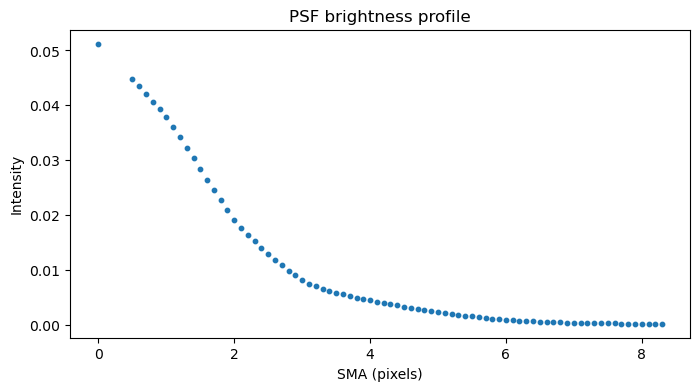

In [84]:
plt.figure(figsize=(8, 4))

plt.scatter(isolist.sma, isolist.intens, s=10)
plt.title("PSF brightness profile")
plt.xlabel("SMA (pixels)")
plt.ylabel("Intensity")

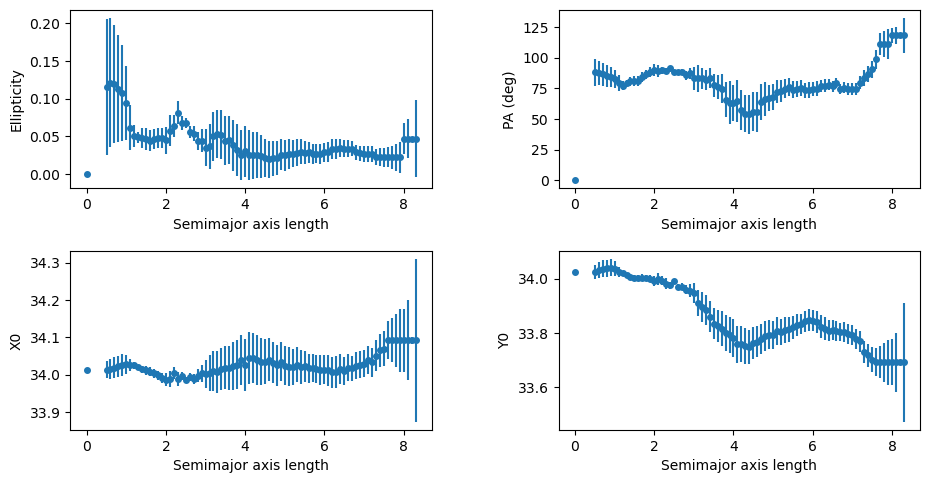

In [87]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Ellipticity')

plt.subplot(222)
plt.errorbar(isolist.sma, isolist.pa/np.pi*180., yerr=isolist.pa_err/np.pi* 80., fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('PA (deg)')

plt.subplot(223)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('X0')

plt.subplot(224)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Y0')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)